In [7]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [8]:
df = pd.read_csv('seattle-weather.csv')
df = df.drop(columns = ['weather'])
df

,date,precipitation,temp_max,temp_min,wind
0,2012-01-01,0.0,12.8,5.0,4.7
1,2012-01-02,10.9,10.6,2.8,4.5
2,2012-01-03,0.8,11.7,7.2,2.3
3,2012-01-04,20.3,12.2,5.6,4.7
4,2012-01-05,1.3,8.9,2.8,6.1
...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9
1457,2015-12-28,1.5,5.0,1.7,1.3
1458,2015-12-29,0.0,7.2,0.6,2.6
1459,2015-12-30,0.0,5.6,-1.0,3.4


In [9]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
dtype: int64

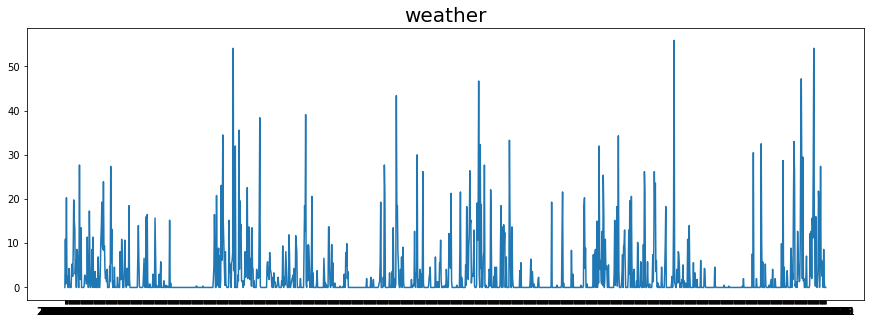

In [12]:
x = df['date'].values
y = df['precipitation'].values
 
plt.figure(figsize=(15,5))
plt.plot(x, y)
plt.title('weather', fontsize=20);

In [14]:
from sklearn.preprocessing import MinMaxScaler

data = df['precipitation'].values
data_new = data.reshape(-1,1)
scaler = MinMaxScaler()
data_scaler = scaler.fit_transform(data_new)
data_scaler = data_scaler.reshape(1,-1)
data_scaler = np.hstack(data_scaler)
data_scaler

array([0.        , 0.19499106, 0.01431127, ..., 0.        , 0.        ,
       0.        ])

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, data_scaler, test_size=0.2, random_state=0, shuffle=False)
print(len(X_train), len(X_test))

1168 293


In [26]:
set_latih = windowed_dataset(
    y_train,
    window_size=64, 
    batch_size=200, 
    shuffle_buffer=1000
)

val_test = windowed_dataset(
    y_test,
    window_size = 64,
    batch_size = 200,
    shuffle_buffer = 1000
)

In [27]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [28]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_mae')<0.1):
            print("\nMae telah kurang dari 10%!")
            self.model.stop_training = True
callbacks = myCallback()

In [29]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [30]:
history = model.fit(set_latih,
                    epochs=100,
                    validation_data=val_test, 
                    callbacks=[callbacks])

Epoch 1/100
6/6 [==============================] - 5s 299ms/step - loss: 0.0078 - mae: 0.0533 - val_loss: 0.0121 - val_mae: 0.0578

Mae telah kurang dari 10%!


In [ ]:
Nama : Muhammad Dhafi Alfaridzi
Email : M315X0844@dicoding.org
SIB_Group = M07